Enter the Stock Symbol (e.g., AAPL, TSLA, BTC-USD, ETH-USD):  BTC-USD


Successfully fetched data from Polygon.io for BTC-USD


,adj_close
date,
2022-09-24,18923.19
2022-09-25,18808.61
2022-09-26,19228.00
2022-09-27,19077.57
2022-09-28,19400.00


[*********************100%***********************]  1 of 1 completed

Successfully fetched data from yfinance for BTC-USD


,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


Epoch 1/100


C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


262/262 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0066
Epoch 2/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0017
Epoch 3/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0022
Epoch 4/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0018
Epoch 5/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0011
Epoch 6/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0011
Epoch 7/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 9.7953e-04
Epoch 8/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 7.4201e-04
Epoch 9/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 7.1493e-04
Epoch 10/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 6.4298e-04
Epoch 11/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 7.1595e-04
Epoch 12/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 4.9254e-04
Epoch 13/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 5.0419e-04
Epoch 14/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 7.6471e-04
Epoch 15/

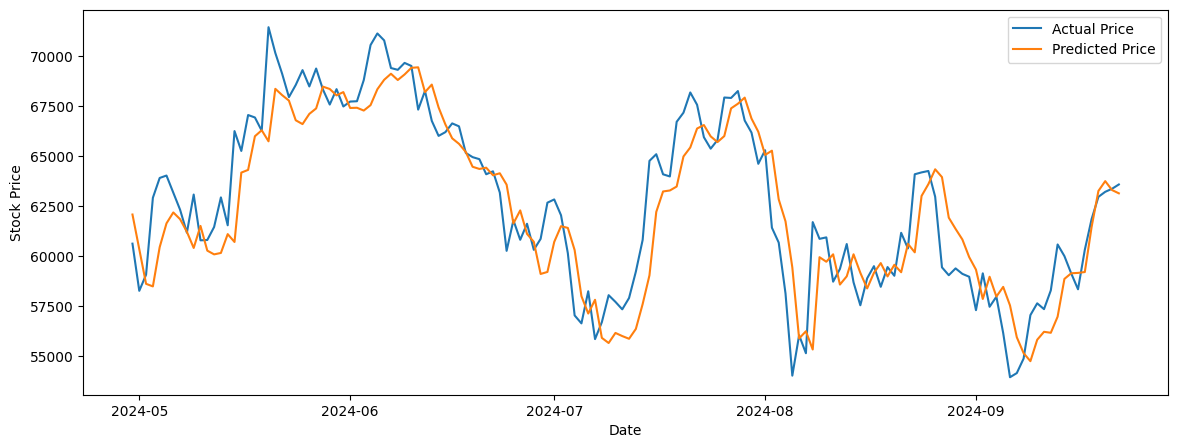

Model RMSE: 62427.60929031279
Model saved as BTC-USD_lstm_model.h5


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
import math
import requests
from datetime import datetime
import yfinance as yf

# Polygon.io API key
API_KEY = '27DzQ9ENavxTqAh6IaO4kFVZZQnc3uDk'

# Function to fetch stock data from Polygon.io
def get_polygon_data(symbol):
    # Correct symbols for cryptocurrencies
    if symbol == "BTC-USD":
        symbol = "X:BTCUSD"
    elif symbol == "ETH-USD":
        symbol = "X:ETHUSD"
    
    url = f'https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/day/2004-01-01/{datetime.now().date()}?adjusted=true&sort=asc&limit=5000&apiKey={API_KEY}'
    response = requests.get(url)
    data = response.json()
    
    if 'results' not in data:
        raise ValueError(f"Failed to fetch data for {symbol}. Check the symbol or API response.")
    
    df = pd.DataFrame(data['results'])
    df['date'] = pd.to_datetime(df['t'], unit='ms')
    df.set_index('date', inplace=True)
    df['adj_close'] = df['c']  # 'c' is assumed to be adjusted close price
    return df[['adj_close']]

# Function to fetch stock data from Yahoo Finance
def get_yfinance_data(symbol):
    df = yf.download(symbol, start="2004-01-01")
    return df[['Close']]

# Get stock symbol from user input (Jupyter-specific)
stock = input("Enter the Stock Symbol (e.g., AAPL, TSLA, BTC-USD, ETH-USD): ").upper()

# Fetch data from Polygon.io
stock_data_polygon = None
yfinance_data = None

try:
    stock_data_polygon = get_polygon_data(stock)
    print(f"Successfully fetched data from Polygon.io for {stock}")
    display(stock_data_polygon.head())
except Exception as e:
    print(f"Error fetching data from Polygon.io: {e}")

try:
    yfinance_data = get_yfinance_data(stock)
    print(f"Successfully fetched data from yfinance for {stock}")
    display(yfinance_data.head())
except Exception as e:
    print(f"Error fetching data from yfinance: {e}")

# Only proceed if both stock_data and yfinance_data were fetched successfully
if stock_data_polygon is not None and yfinance_data is not None:
    # Align yfinance data to the Polygon.io date range
    start_date = stock_data_polygon.index.min()
    end_date = stock_data_polygon.index.max()
    yfinance_data_filtered = yfinance_data.loc[start_date:end_date]

    # Merge data on the date index
    merged_data = pd.merge(stock_data_polygon, yfinance_data_filtered, left_index=True, right_index=True, how='outer')
    merged_data.ffill(inplace=True)  # Forward fill missing values

    # Preprocessing
    merged_data = merged_data.dropna()
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(merged_data['adj_close'].values.reshape(-1, 1))

    # Train/Test split (80% train, 20% test)
    train_len = int(len(scaled_data) * 0.8)
    train_data = scaled_data[:train_len]
    test_data = scaled_data[train_len - 60:]  # 60-day overlap

    # Create training data
    x_train, y_train = [], []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])

    # Create testing data
    x_test, y_test = [], []
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
        y_test.append(test_data[i, 0])

    # Convert to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)

    # Reshape for LSTM model
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train model
    model.fit(x_train, y_train, batch_size=2, epochs=100)

    # Predict on test data
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Plot the results
    plt.figure(figsize=(14,5))
    plt.plot(merged_data.index[train_len:], merged_data['adj_close'][train_len:], label='Actual Price')
    plt.plot(merged_data.index[train_len:], predictions, label='Predicted Price')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, predictions))
    print(f"Model RMSE: {rmse}")

    # Save the model
    model.save(f'{stock}_lstm_model.h5')
    print(f"Model saved as {stock}_lstm_model.h5")
else:
    print(f"Stock data for {stock} could not be fetched. Please try again.")
